#Домашнее задание № 5. Сингулярный спектральный анализ.

##Загрузим необходимые данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# загрузим данные
!wget 'https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._Лекция_tsml.zip'

--2025-02-27 05:52:04--  https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_tsml.zip
Resolving u.netology.ru (u.netology.ru)... 213.180.193.247, 2a02:6b8::1da
Connecting to u.netology.ru (u.netology.ru)|213.180.193.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769056 (751K) [application/x-zip-compressed]
Saving to: ‘1._Лекция_tsml.zip’

1._Лекция_tsml.zip  100%[===================>] 751.03K   813KB/s    in 0.9s    

2025-02-27 05:52:06 (813 KB/s) - ‘1._Лекция_tsml.zip’ saved [769056/769056]



In [3]:
# распакуем
import zipfile

with zipfile.ZipFile('/content/1._Лекция_tsml.zip', 'r') as zip_ref:
    zip_ref.extractall('unpacked_files')

В качестве ряда для анализа выберу monthly_boston_armed_robberies_j. Он мне кажется самым интересным.

In [4]:
# 2. ежемесячные_бостонские вооруженные_ ограбления_j
monthly_boston_armed_robberies_j = pd.read_csv('/content/unpacked_files/Series/monthly-boston-armed-robberies-j.csv')

In [5]:
series = monthly_boston_armed_robberies_j['Count']

In [6]:
# вывод графиков
def chart_2(series_1, series_2=None, title=None):
    plt.figure(figsize=(14, 7))
    plt.plot(series_1, label='Временной ряд')
    if series_2 is not None:
        plt.plot(series_2, label=title)
    plt.title('Визуальное сравнение полученного временного ряда')
    plt.xlabel('Время')
    plt.ylabel('Величина')
    plt.grid(False)
    plt.legend()
    plt.show()

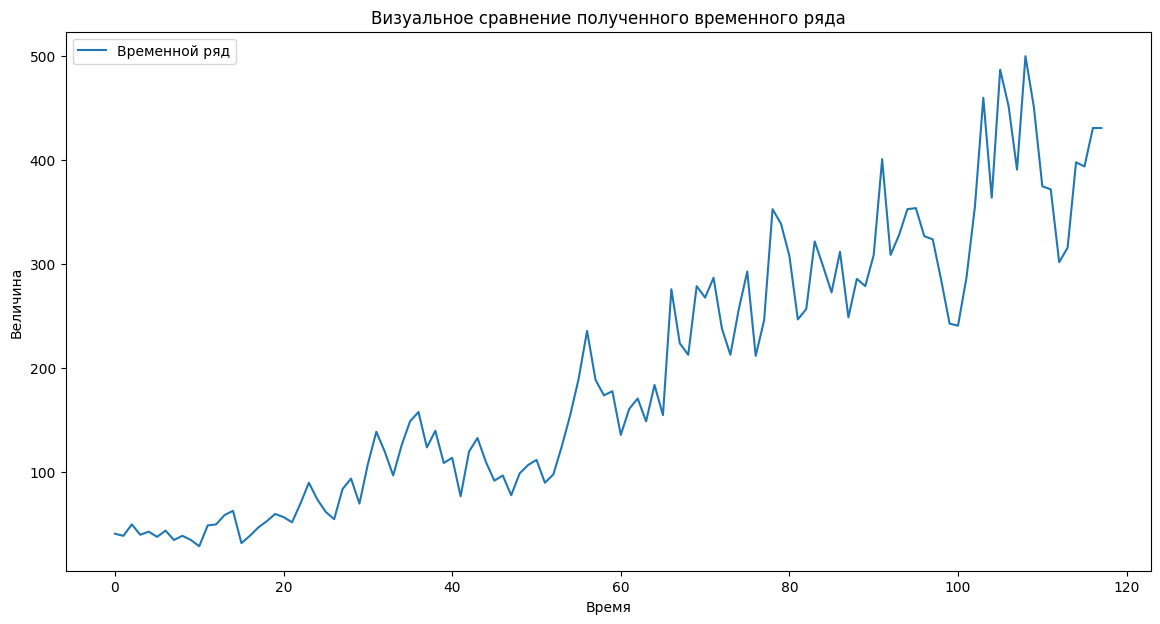

In [7]:
# посмотрим на график
chart_2(series)

##SSA

Разложение

In [9]:
import scipy.linalg
import seaborn as sns

In [48]:
# настройки рисунка
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# установим цветовой цикл по умолчанию
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# маленький 2D-матричный плоттер, без меток x и y
def plot_2d(m, title=''):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [11]:
# функция для матрицы Ханкеля
def embed(TS, window_length):
    # вставим временной ряд в матрицу Ханкеля
    K = len(TS) - window_length + 1
    trajectory_matrix = scipy.linalg.hankel(TS, np.zeros(window_length)).T[:, : K]
    return trajectory_matrix

In [12]:
# посмотрим на размер ряда
len(series)

118

In [63]:
# зададим размер окна
# принимаю, что он совпадает с предполагаемой сезонностью х 3
window_length = 36

In [64]:
# получим матрицу Ханкеля
trajectory_matrix = embed(series, window_length)
trajectory_matrix[1]

array([ 39.,  50.,  40.,  43.,  38.,  44.,  35.,  39.,  35.,  29.,  49.,
        50.,  59.,  63.,  32.,  39.,  47.,  53.,  60.,  57.,  52.,  70.,
        90.,  74.,  62.,  55.,  84.,  94.,  70., 108., 139., 120.,  97.,
       126., 149., 158., 124., 140., 109., 114.,  77., 120., 133., 110.,
        92.,  97.,  78.,  99., 107., 112.,  90.,  98., 125., 155., 190.,
       236., 189., 174., 178., 136., 161., 171., 149., 184., 155., 276.,
       224., 213., 279., 268., 287., 238., 213., 257., 293., 212., 246.,
       353., 339., 308., 247., 257., 322.])

In [65]:
# проверим
series[:(len(series)-window_length+2)]

,Count
0,41
1,39
2,50
3,40
4,43
...,...
79,339
80,308
81,247
82,257


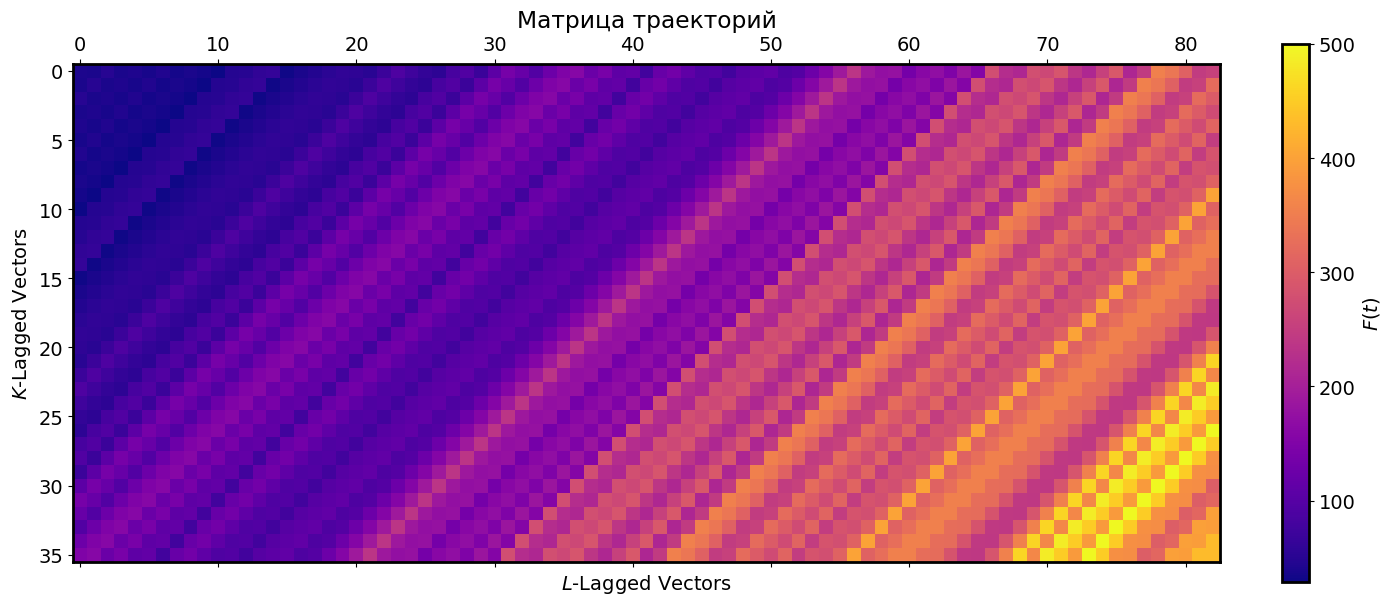

In [66]:
# посмотрим на ее диагональную красоту
ax = plt.matshow(trajectory_matrix)
plt.xlabel('$L$-Lagged Vectors')
plt.ylabel('$K$-Lagged Vectors')
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title('Матрица траекторий');

In [67]:
# разложим матрицу траекторий и сформируем ее элементарные матрицы
def decompose(trajectory_matrix):
    d = np.linalg.matrix_rank(trajectory_matrix)
    U, Sigma, V = np.linalg.svd(trajectory_matrix)
    V = V.T
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

    if not np.allclose(trajectory_matrix, X_elem.sum(axis=0), atol=1e-10):
        print("WARNING: The sum of X's elementary matrices is not equal to X!")

    return d, U, V, X_elem

In [68]:
d, U, V, X_elem = decompose(trajectory_matrix)

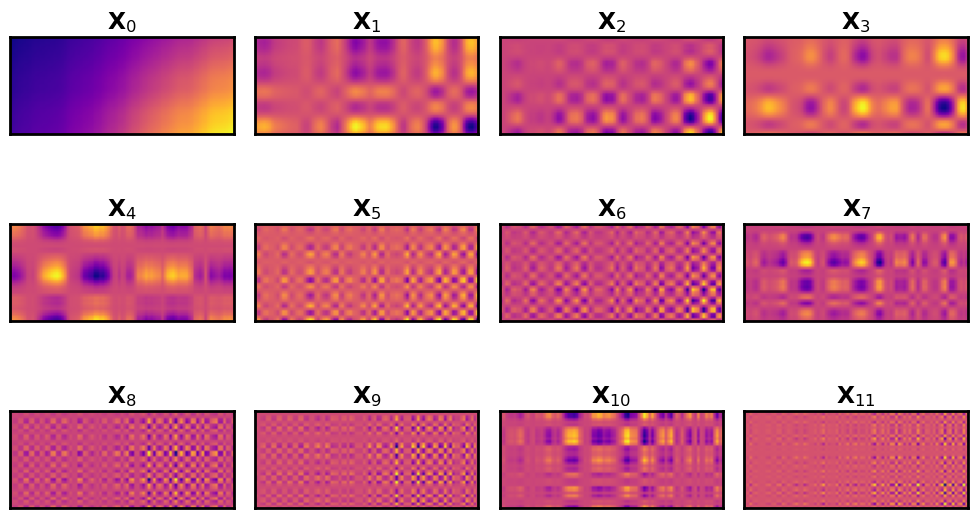

In [69]:
# посмотрим
n = min(12, d)
for i in range(n):
    plt.subplot(4, 4, i+1)
    title = '$\mathbf{X}_{' + str(i) + '}$'
    plot_2d(X_elem[i], title)
plt.tight_layout()

Реконструкция

In [70]:
# сгруппируем сингулярные значения и векторы в матрицы
def group(trajectory_matrix, rank, singular_values, singular_vectors):

    V = {i: np.matmul(trajectory_matrix.T, singular_vectors[:,i]) / singular_values[i] for i in range(rank)}
    # ранг каждой матрицы равен 1
    X = {
        i: np.matmul(singular_values[i]*singular_vectors[:,i].reshape(-1,1), V[i].reshape(-1,1).T)
        for i in range(rank)
    }
    return X

In [71]:
# принимем сгруппированные матрицы в качестве входных данных
# и возвратим реконструированный временной ряд
def diagonal_averaging(X, m):
    # антидиагональное усреднение заданной матрицы Ханкеля
    if m > len(X):
        raise ValueError('Number of singular values cannot be greater than the rank of the trajectory matrix.')

    result = []
    matrix = np.sum([X[i] for i in range(m)], axis=(0))
    rows, columns = matrix.shape
    rows_star, columns_star = min(rows, columns), max(rows, columns)

    for k in range(1-columns_star, rows_star):
        identity_matrix = np.eye(columns_star, k=k, dtype='bool')[::-1][:rows_star,:]
        identity_matrix_sum = np.sum(identity_matrix)
        mask = np.ma.masked_array(matrix, mask=1-identity_matrix)
        average = mask.sum() / identity_matrix_sum
        result.append(average)

    return pd.DataFrame(result).rename(columns={0: 'reconstruction'})

In [72]:
# выбираем первую матрицу сгруппированного разложения и выполняем диагональное усреднение
# в результате получаем восстановленный временной ряд
reconstructed_time_series = diagonal_averaging(X, 1)
reconstructed_time_series[:5]

NameError: name 'X' is not defined

In [ ]:
# результат из первых 2-х матриц
reconstructed_time_series = diagonal_averaging(X, 2)

In [ ]:
# сравним
reconstructed_time_series['original'] = pd.DataFrame(series)['Count']
reconstructed_time_series

In [ ]:
trajectory_matrix = embed(series, window_length=12)

In [ ]:
trajectory_matrix

In [ ]:
rank, s_values, s_vectors = decompose(trajectory_matrix)

In [ ]:
X = group(trajectory_matrix, rank, s_values, s_vectors)

In [ ]:
reconstructed = diagonal_averaging(X, m=12)

series["reconstruction"] = reconstructed["reconstruction"].values

In [ ]:
# Plot original and reconstructed series
ts = pd.DataFrame(series)

plt.style.use("ggplot")
plt.figure(figsize=(11, 4))

sns.lineplot(data=ts, x=ts.index, y="price", label="Original")
sns.lineplot(data=ts, x=ts.index, y="reconstruction", label="Reconstructed");